Checking STIS spectra and coadding if needed

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [27]:
ls

odlm21010_sx1.fits  odlm21040_x1d.fits  odlm21060_x1d.fits
odlm21020_x1d.fits  odlm21050_tag.fits  stis_check.ipynb
odlm21030_x1d.fits  odlm21050_x1d.fits  stuff/


In [28]:
x1ds = glob.glob('*x1d*')

odlm21030_x1d.fits


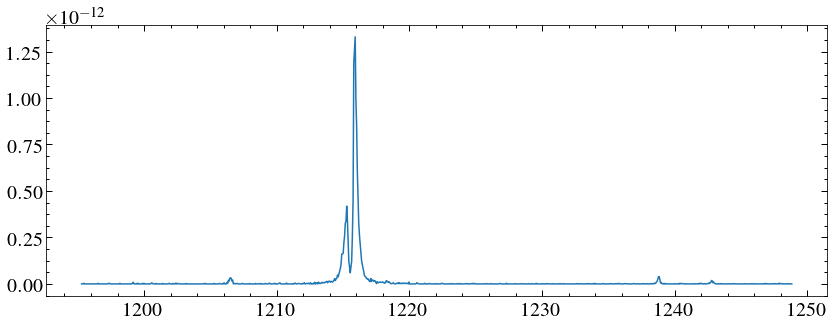

odlm21060_x1d.fits


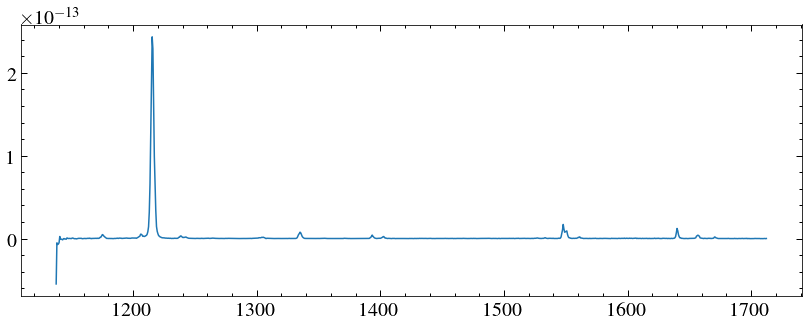

odlm21050_x1d.fits


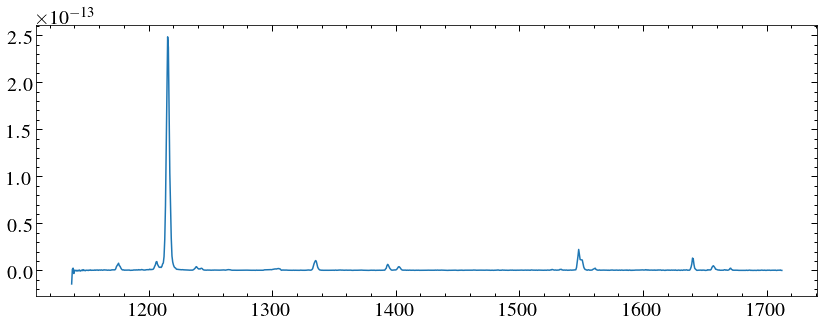

odlm21040_x1d.fits


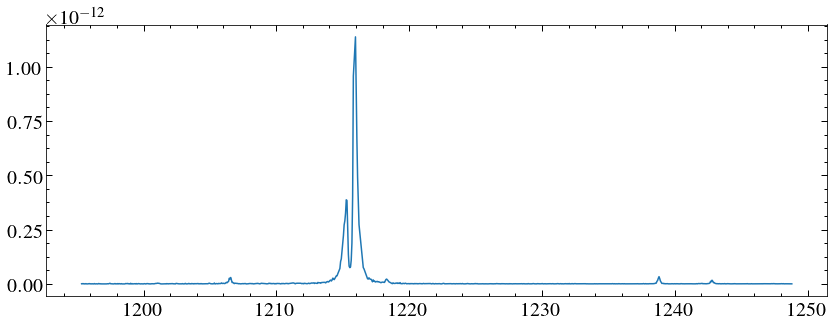

odlm21020_x1d.fits


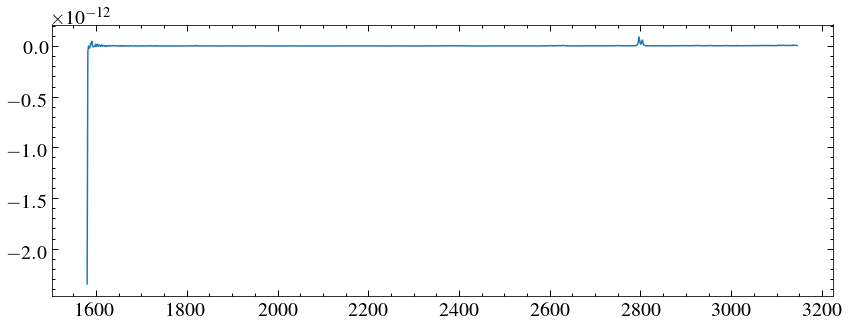

In [29]:
for s in x1ds:
    print(s)
    data = fits.getdata(s,1)
    for dt in data:
        plt.plot(dt['WAVELENGTH'][dt['DQ']==0], dt['FLUX'][dt['DQ']==0])
    plt.show()

Let's look at chopping off that flux drop 

odlm21030_x1d.fits
odlm21060_x1d.fits
odlm21050_x1d.fits
odlm21040_x1d.fits
odlm21020_x1d.fits


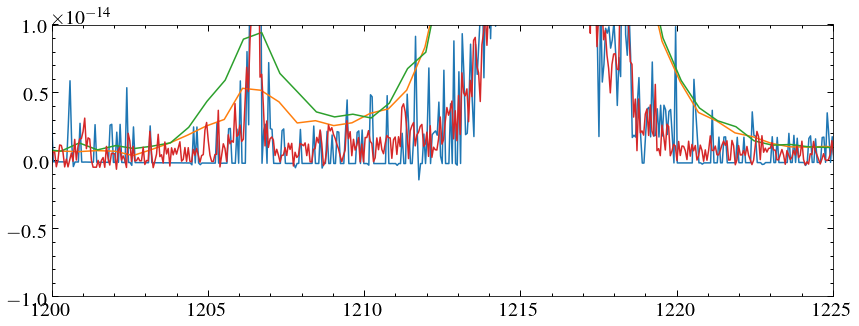

In [30]:
bad = 'odlm21020_x1d.fits'
for s in x1ds:
    print(s)
    data = fits.getdata(s,1)
    for dt in data:
        if bad in s:
            plt.plot(dt['WAVELENGTH'][dt['WAVELENGTH']>1600], dt['FLUX'][dt['WAVELENGTH']>1600])
        else:
            plt.plot(dt['WAVELENGTH'], dt['FLUX'])
    #plt.show()
    plt.xlim(1200, 1225)
    plt.ylim(-0.1e-13, 0.1e-13)

In [31]:
for s in x1ds:
    data = fits.getdata(s,1)
    w = data[0]['WAVELENGTH']
    print(s, w[0], w[-1])


odlm21030_x1d.fits 1194.81342425189 1249.352968860598
odlm21060_x1d.fits 1119.1184042991194 1715.735427461613
odlm21050_x1d.fits 1119.1474971809891 1715.7670136535671
odlm21040_x1d.fits 1194.8030171119033 1249.3432603513886
odlm21020_x1d.fits 1569.4704284210939 3153.4983896202493


So... coadd spectra with same cenwave, see where we go from there.

In [32]:
def spectra_adder(xaxis,flux_files,error_files): #takes spectra and does a weighted average, returning the weighted spectra and error
    if len(flux_files) > 1:
        weight_flux=np.zeros(len(xaxis))
        weight_error=np.zeros(len(xaxis)) #array to hold the error on the weighed average
        for e in range(len(xaxis)):
            points=flux_files[:,e]
            epoints=error_files[:,e]#creates a list of the values from each image at the same point
            points, epoints=points[(points>0.)], epoints[(points>0.)]
            plotdata=np.ma.average(points,weights=(1./epoints**2))
            if np.isnan(plotdata)==True:
                  plotdata=0.0
            if len(epoints)>1.:
                  weighterr=(np.ma.average((points-plotdata)**2.,weights=(1./epoints**2)))**(1./2.)
            elif len(epoints)==1:
                  weighterr=epoints[0]
            else:
                weighterr=0.0
            if np.isnan(weighterr)==True:
                  weighterr=0.0
            weight_flux[e]=plotdata
            weight_error[e]=weighterr
    else:
        weight_flux=flux_files[0]
        weight_error=error_files[0]
    return weight_flux,weight_error

In [33]:
for s in x1ds:
    hdr = fits.getheader(s,0)
    print(hdr['OPT_ELEM'])


G140M
G140L
G140L
G140M
G230L


In [34]:
G140M = []
G140L = []
G230L = []

for s in x1ds:
    hdr = fits.getheader(s,0)
    grt = hdr['OPT_ELEM']
    print(s, grt)
    if grt == 'G140M':
        G140M.append(s)
    if grt == 'G140L':
        G140L.append(s)
    if grt == 'G230L':
        G230L.append(s)
print(G140M)
print(G140L)
print(G230L)

odlm21030_x1d.fits G140M
odlm21060_x1d.fits G140L
odlm21050_x1d.fits G140L
odlm21040_x1d.fits G140M
odlm21020_x1d.fits G230L
['odlm21030_x1d.fits', 'odlm21040_x1d.fits']
['odlm21060_x1d.fits', 'odlm21050_x1d.fits']
['odlm21020_x1d.fits']


First check for differences between each spectrum, see if the flare(s) made a difference.

odlm21030_x1d.fits
odlm21040_x1d.fits


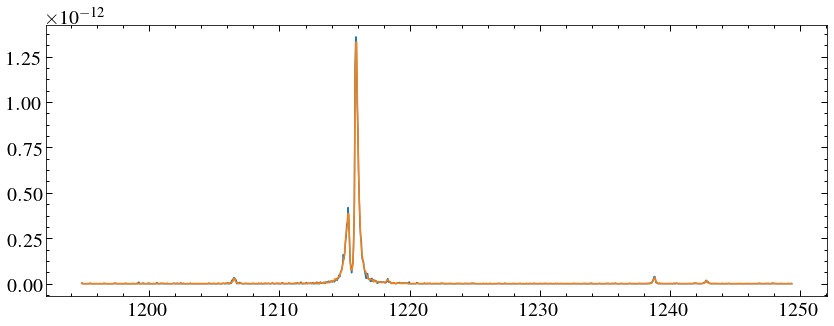

odlm21060_x1d.fits
odlm21050_x1d.fits


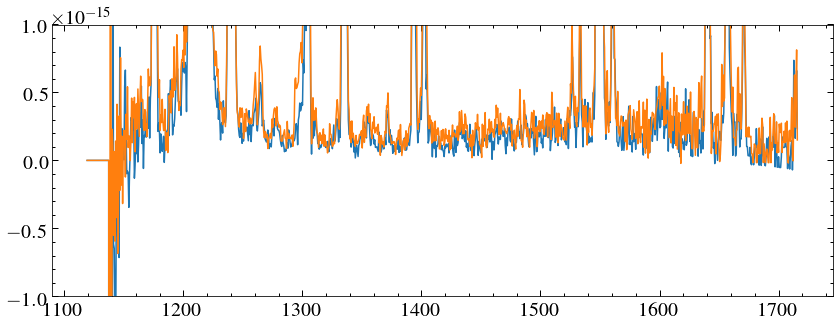

In [35]:
bad = 'odlm21020_x1d.fits'
for s in G140M:
    print(s)
    data = fits.getdata(s,1)
    for dt in data:
        if bad in s:
            plt.plot(dt['WAVELENGTH'][dt['WAVELENGTH']>1600], dt['FLUX'][dt['WAVELENGTH']>1600])
        else:
            plt.plot(dt['WAVELENGTH'], dt['FLUX'])
plt.show()
for s in G140L:
    print(s)
    data = fits.getdata(s,1)
    for dt in data:
        if bad in s:
            plt.plot(dt['WAVELENGTH'][dt['WAVELENGTH']>1600], dt['FLUX'][dt['WAVELENGTH']>1600])
        else:
            plt.plot(dt['WAVELENGTH'], dt['FLUX'])
plt.ylim(-0.01e-13,0.01e-13)
plt.show()
            

Ok looks like the flux is significantly higher in the odlm21050_x1d.fits G140L spectrum. Let's get the lightcurve, see what we can save.

In [36]:
lc = Table.read('../../../gj674_flare/gj674_sts_g140l_lightcurve_10s_all_flux.ecsv')

<ErrorbarContainer object of 3 artists>

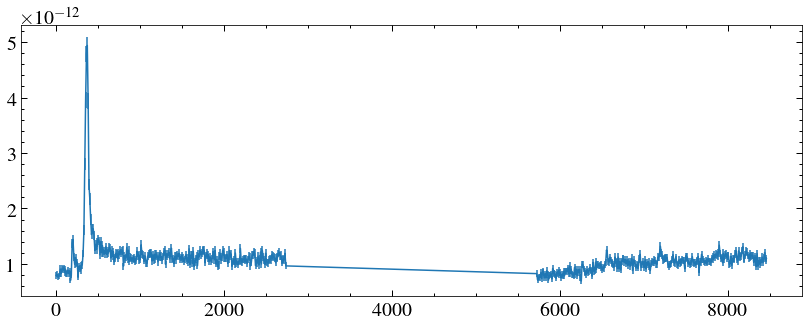

In [37]:
plt.errorbar(lc['t'], lc['flux'], yerr=lc['error'])

Ok so I should be able to cut it out. Does STIS have the equivalent spectra cutting routines to COS? Have asked helpdesk. CSF thinks we can just not use the in-flare spectrum, especially as it doesn't return to the pre-flare flux. We could do with a metric for whether or not to include a flaring spectrum - intergrated flux?

In [38]:
iflux = []
for s in G140L:
    data = fits.getdata(s,1)
    iflux.append(np.trapz(data[0]['FlUX'], data[0]['WAVELENGTH']))
print(iflux)
print(max(iflux)/min(iflux))
    

[1.005167057085643e-12, 1.1790365801248678e-12]
1.1729757474775764


So we could take 10% as a barrier? Wait on helpdesk before doing anything else with G140L

20190227 Helpdesk recommends the inttag tool.

In [39]:
import stistools

In [40]:
flare_end = 1000
#stistools.inttag.inttag('odlm21050_tag.fits', 'noflare', starttime=flare_end)

Huh. Have emailed... inttag will not be on conda for a while. So skip that spectrum for now, just need to combine the G140M spectra.

In [41]:
for s in G140M:
    print(s)
    data = fits.getdata(s,1)
    print(len(data[0]['WAVELENGTH']))

odlm21030_x1d.fits
1024
odlm21040_x1d.fits
1024


In [42]:
w = []
fs= []
es = []
dqs = []
for s in G140M:
    data = fits.getdata(s,1)[0]
    w1, f1, e1, dq1 = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
    #for i in range(len(f1)):
     #   if dq[i] != 0:
      #      f1[i], e1[i] = 0., 0.
    w = w1
    fs.append(f1)
    es.append(e1)
    dqs.append(dq1)
w = np.array(w)
fs = np.array(fs)
es = np.array(es)
dqs = np.array(dqs)
dq = np.amax(dqs, axis=0 )


In [43]:
f, e = spectra_adder(w, fs, es)

/home/david/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/ma/extras.py:607: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/home/david/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in true_divide
  del sys.path[0]


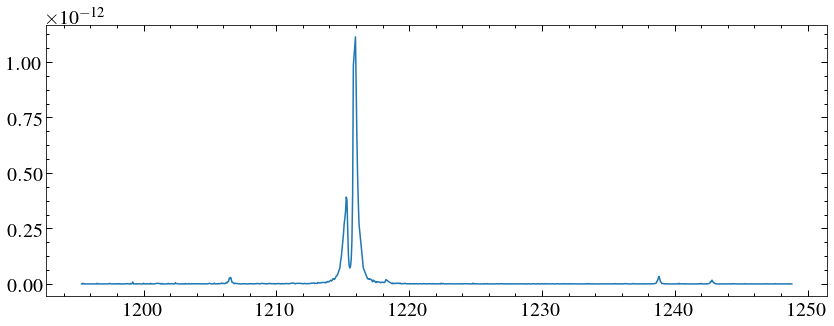

In [44]:
plt.plot(w[dq==0],f[dq==0])

odlm21030_x1d.fits
odlm21040_x1d.fits


(-1e-15, 5e-15)

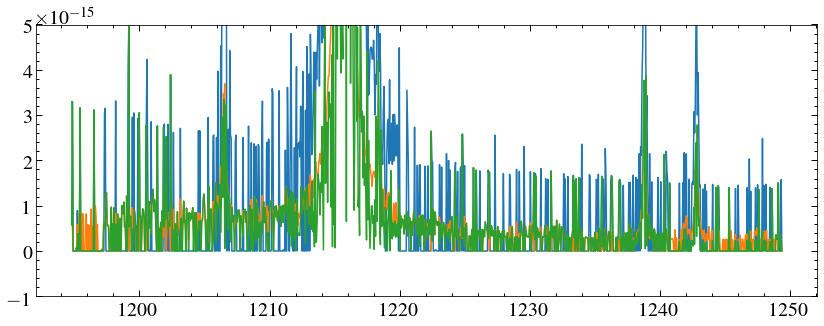

In [45]:
for s in G140M:
    print(s)
    dt = fits.getdata(s,1)[0]
    plt.plot(dt['WAVELENGTH'], dt['ERROR'])
plt.plot(w,e)
plt.ylim(-0.01e-13, 0.05e-13)

odlm21030_x1d.fits
odlm21040_x1d.fits
1024 151


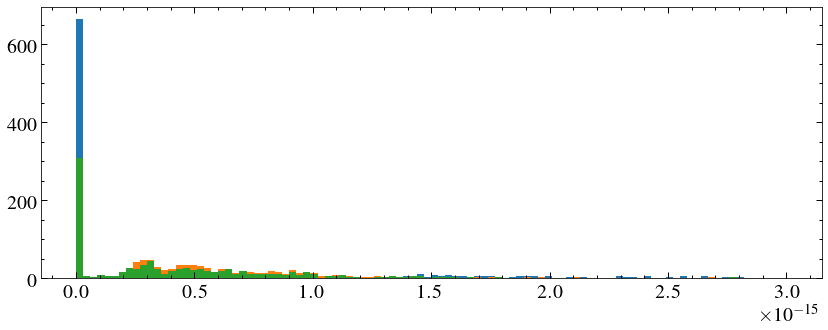

In [46]:
bins = 100
r = [0, 0.3e-14]
for s in G140M:
    print(s)
    dt = fits.getdata(s,1)[0]
    plt.hist(dt['ERROR'], bins=bins, range=r)
plt.hist(e, bins=bins, range=r)
print(len(e),len(e[e==0]))

Quick play with spectutils, see if their coadder is better than mine...

In [47]:
from specutils import Spectrum1D

In [51]:
s1 = Spectrum1D(spectral_axis=w*u.AA, flux=fs[0]*(u.erg/u.s/u.cm**2/u.AA))

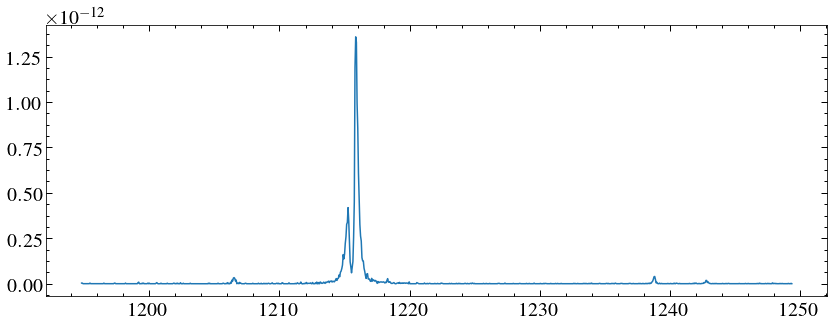

In [52]:
plt.plot(s1.spectral_axis, s1.flux)

Looks like they don't really have a coadder?

In [53]:
def spectra_adder(fluxes, errors):
    """
    combines the flux at each overlap
    """
    weight_f = np.average(fluxes, axis =0, weights=(1/errors))
    weight_e = np.average((weight_f - fluxes)**2, axis=0, weights = (1/errors))**0.5
    return weight_f, weight_e


In [54]:
f2, e2  = spectra_adder(fs, es)

(-1e-15, 5e-15)

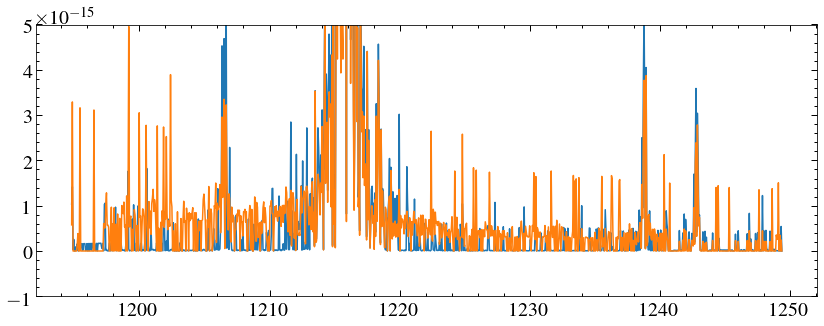

In [58]:
plt.plot(w, e2)
plt.plot(w,e)
plt.ylim(-0.01e-13, 0.05e-13)

(array([308.,   6.,   3.,   8.,   6.,   6.,  15.,  26.,  25.,  35.,  44.,
         25.,  11.,  19.,  24.,  26.,  22.,  24.,  19.,  15.,  18.,  25.,
         12.,  18.,  12.,  10.,  11.,  12.,  11.,   8.,  15.,   9.,  15.,
         11.,   2.,   5.,   7.,   8.,   4.,   3.,   2.,   1.,   4.,   4.,
          5.,   4.,   4.,   6.,   5.,   2.,   3.,   3.,   3.,   3.,   2.,
          3.,   1.,   2.,   2.,   3.,   0.,   1.,   0.,   0.,   2.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   1.,   0.,   1.,   1.,   1.,   0.,   1.,
          2.,   1.,   0.,   2.,   4.,   0.,   2.,   1.,   0.,   0.,   2.,
          2.]),
 array([0.00e+00, 3.00e-17, 6.00e-17, 9.00e-17, 1.20e-16, 1.50e-16,
        1.80e-16, 2.10e-16, 2.40e-16, 2.70e-16, 3.00e-16, 3.30e-16,
        3.60e-16, 3.90e-16, 4.20e-16, 4.50e-16, 4.80e-16, 5.10e-16,
        5.40e-16, 5.70e-16, 6.00e-16, 6.30e-16, 6.60e-16, 6.90e-16,
        7.20e-16, 7.50e-16, 7.80e-16, 8.10e-16

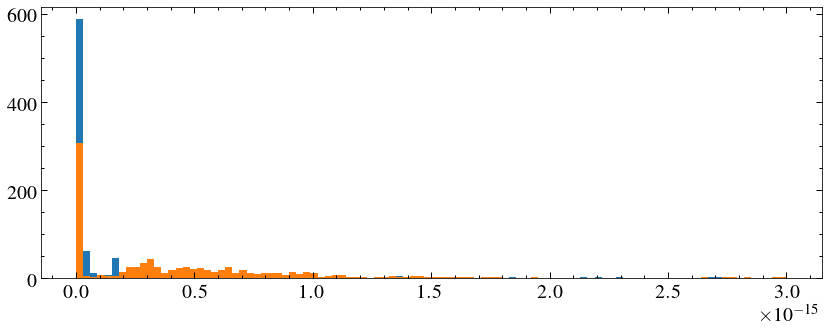

In [59]:
plt.hist(e2, bins=bins, range=r)
plt.hist(e, bins=bins, range=r)

That seems to work better, eventually I need to write a good spec adder function. Let's table that up.

In [62]:
data = Table([w*u.AA, f2*u.erg/u.cm**2/u.s/u.AA, e2*u.erg/u.cm**2/u.s/u.AA, dq], names = ['WAVELENGTH', 'FLUX', 'ERROR','DQ'] )
ascii.write(data, 'GJ674_G140M_coadd.ecsv', delimiter=',', format='ecsv')

Making a copy of the G140L spectrum without a flare ...60 is the one.

In [64]:
G140L

['odlm21060_x1d.fits', 'odlm21050_x1d.fits']

Lastly, check the CCD spectrum.

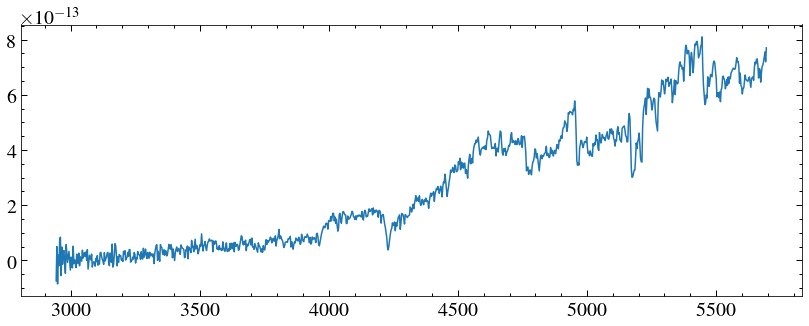

In [74]:
ccd = 'odlm21010_sx1.fits'
data = fits.getdata(ccd)[0]
clip_st, clip_end = 20,-1 #points to clip off ccd spectrum  
plt.plot(data['WAVELENGTH'][clip_st:clip_end], data['FLUX'][clip_st:clip_end])

Exciting spectrum. Looks fine though, stis is sorted!
One last thing, find where to clip the G230L spectrum

In [75]:
G230L

['odlm21020_x1d.fits']

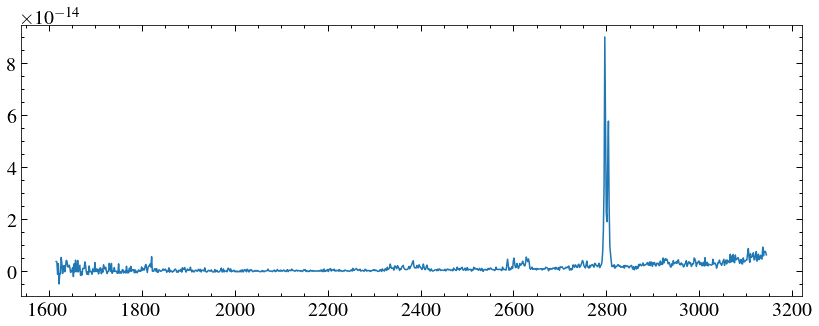

In [84]:
data = fits.getdata(G230L[0])[0]
clip_st, clip_end = 30,-6#points to clip off g230L spectrum  
plt.plot(data['WAVELENGTH'][clip_st:clip_end], data['FLUX'][clip_st:clip_end])

And what do they all look like together?

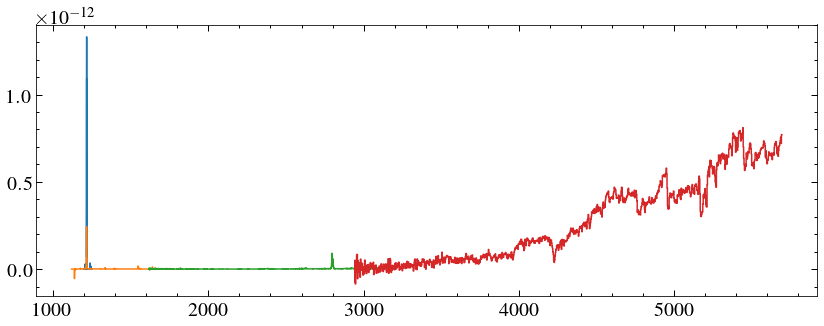

In [85]:
data = Table.read('GJ674_G140M_coadd.ecsv')
plt.step(data['WAVELENGTH'], data['FLUX'])
data = fits.getdata('GJ674_G140L_noflare_x1d.fits', 1)[0]
plt.step(data['WAVELENGTH'], data['FLUX'])
data = fits.getdata(G230L[0])[0]
clip_st, clip_end = 30,-6 
plt.step(data['WAVELENGTH'][clip_st:clip_end], data['FLUX'][clip_st:clip_end])
ccd = 'odlm21010_sx1.fits'
data = fits.getdata(ccd)[0]
clip_st, clip_end = 20,-1 #points to clip off ccd spectrum  
plt.step(data['WAVELENGTH'][clip_st:clip_end], data['FLUX'][clip_st:clip_end])